In [1]:
import pandas as pd
import numpy as np
import pickle
import argparse
import sys
import os
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, auc
import matplotlib.pyplot as plt
import os
os.chdir(os.getcwd())

In [2]:
os.getcwd()

'/mnt/github/RiboVsPolyA/examples'

### Following is code from RF_deploy.py

In [3]:
def gene_checker(input_file):
    '''
    Function checks the input file's genes.
    The intersection between the input file's genes and the predetermined classifier genes is taken.
    Then the function checks for genes are not present in the input file.
    For those genes, the expression vector is set to 0.
    A new dataframe is returned with the correct order of genes.

    Parameters
    ----------
    input_file; pandas df - shape should be (samples x genes)
    
    Returns
    ---------
    new_input_file; pandas df - shape (samples x genes)
    '''
    
    classifier_genes = np.loadtxt('../data_test/ClassifierGenes.txt', dtype='str')
    classifier_genes_meanexpr = np.load('../data_test/ClassifierGenes_MeanExpr.npy', allow_pickle=True).item()
    common_genes = set(classifier_genes).intersection(input_file.columns)
    uncommon_genes = set(classifier_genes).difference(input_file.columns)
    #new_input_file = input_file.T.loc[classifier_genes].T # seleting classifier selected genes in the classifier determined order
    print(len(common_genes ))
    for gene in uncommon_genes:
        input_file[gene] = [classifier_genes_meanexpr[gene]]*input_file.shape[0]

    new_input_file = input_file.T.loc[classifier_genes].T

    # will fill genes that do not exist in the input with zero
    # if no NAN values, none will be filled
    new_input_file = new_input_file.fillna(0) 
    
    return new_input_file

def deploy(input_file, rf_model=None, model_path=None):

    expr_input = input_file
        
    print('reading input...')
    if isinstance(input_file, pd.DataFrame):
        expr_input = input_file
    else:
        expr_input = pd.read_csv(expr_input, sep='\t', index_col=0)

    print("before gene intersection...")
    print(expr_input.shape)
    expr_input = gene_checker(expr_input) # making sure genes are correct for classifier
    print("After gene intersection...")
    print(expr_input.shape)
    
    if model_path is not None:
        print('applying model...')
        model = pickle.load(open(model_path, 'rb'))
        #print(model)
    if rf_model is not None:
        print('applying model...')
        model = rf_model
        #print(model)
    
    predictions = model.predict(expr_input)
    predict_proba = model.predict_proba(expr_input)
    
    print("saving results...")
    predictions = pd.DataFrame(np.hstack([predictions.reshape(-1,1), predict_proba]), index=expr_input.index, columns=['Ribo', 'Proba_0', 'Proba_1'])

    return predictions

## Applying **balanced** model on FPKM openPBTA RiboD samples

In [4]:
print('reading input')
input_file = pd.read_csv("../data_test/pbta-gene-expression-rsem-fpkm-collapsed.stranded_log2tpm_plus_1.tsv", sep='\t', index_col=0)

reading input


testing max_depth 1
reading input...
before gene intersection...
(970, 53011)
4763
After gene intersection...
(970, 5000)
applying model...
saving results...
Percentage of RiboD samples correctly classified 1.000
testing max_depth 2
reading input...
before gene intersection...
(970, 53248)
5000
After gene intersection...
(970, 5000)
applying model...
saving results...
Percentage of RiboD samples correctly classified 1.000
testing max_depth 3
reading input...
before gene intersection...
(970, 53248)
5000
After gene intersection...
(970, 5000)
applying model...
saving results...
Percentage of RiboD samples correctly classified 1.000
testing max_depth 4
reading input...
before gene intersection...
(970, 53248)
5000
After gene intersection...
(970, 5000)
applying model...
saving results...
Percentage of RiboD samples correctly classified 0.998
testing max_depth 5
reading input...
before gene intersection...
(970, 53248)
5000
After gene intersection...
(970, 5000)
applying model...
saving r

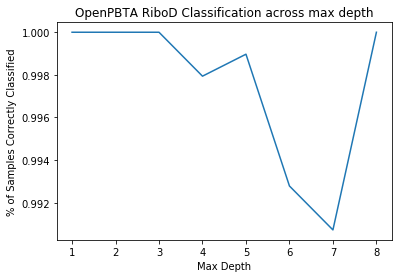

In [ ]:

models_dir = '/mnt/github/RiboVsPolyA/models/'
auc_list = []
acc_list = []
mean_precision_list = []
for depth in np.arange(1,9):
    print('testing max_depth %d'%depth)
    model_path = models_dir+"RiboVsPoly_balanced_max_depth_%d.sav"%depth
    
    balanced_predictions = deploy(input_file, model_path=model_path)
    try:
        res = balanced_predictions.Ribo.value_counts().loc[1.0]/balanced_predictions.shape[0]
        acc_list += [res]
        print('Percentage of RiboD samples correctly classified %.3f'%res)
    except:
        res = 0
        acc_list+=[res]
        print('Percentage of RiboD samples correctly classified %.3f'%res)
    
    y_proba = balanced_predictions.Proba_1.values
    precision, recall, _ = precision_recall_curve(np.array(input_file.shape[0]*[1]), y_proba.flatten(), pos_label=1)
    mean_precision = average_precision_score(np.array(input_file.shape[0]*[1]), y_proba.flatten(), pos_label=1)
    mean_precision_list += [mean_precision]
    balanced_auc = auc(recall, precision)
    
    auc_list += [ balanced_auc]
plt.plot(acc_list)
plt.ylabel('% of Samples Correctly Classified')
plt.xlabel('Max Depth')
plt.title("OpenPBTA RiboD Classification across max depth")
plt.xticks(ticks=np.arange(0,8), labels=map(lambda x:str(x), np.arange(1,9)))
plt.show()
plt.close()

In [ ]:
balanced_predictions = deploy(input_file, model_path='/mnt/github/RiboVsPolyA/models/RiboVsPoly_balanced_max_depth_1.sav')

reading input...
before gene intersection...
(970, 53248)
5000
After gene intersection...
(970, 5000)
applying model...
saving results...


In [ ]:
# Only two sample was predicted to by RiboD
balanced_predictions.Ribo.value_counts()

1.0    970
Name: Ribo, dtype: int64

In [ ]:
balanced_predictions.to_csv("../results/pbta-gene-expression-rsem-fpkm-collapsed.stranded_log2tpm_plus_1.balanced_maxdepth1_results.tsv", sep='\t')

In [ ]:
res = balanced_predictions.Ribo.value_counts().loc[1.0]/balanced_predictions.shape[0]
print('Percentage of RiboD samples correctly classified %.3f'%res)

Percentage of RiboD samples correctly classified 1.000


/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 1.0, 'Balanced Model on FPKM RiboD PBTA')

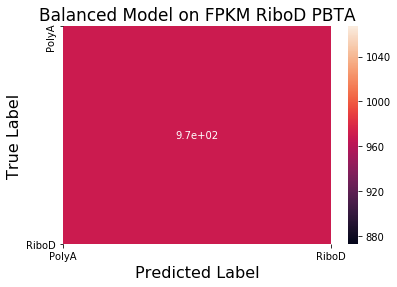

In [ ]:
true_labels = balanced_predictions.shape[0]*[1]
pred_labels = balanced_predictions.Ribo.values

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
#plt.figure(figsize=(10,7))
mat = confusion_matrix(true_labels, pred_labels)
ax = sns.heatmap(mat, annot=True)
ax.set_ylabel("True Label", fontsize=16)
ax.set_xlabel("Predicted Label", fontsize=16)
plt.xticks(ticks=[0,1], labels=['PolyA','RiboD'])
plt.yticks(ticks=[0,1], labels=['PolyA','RiboD'])

ax.set_title("Balanced Model on FPKM RiboD PBTA", fontsize=17)

## Applying **balanced** model on TPM openPBTA RiboD samples

In [ ]:
print('reading input')
input_file = pd.read_csv("../data_test/pbta-gene-expression-kallisto.stranded_log2tpm_plus_1.tsv", sep='\t', index_col=0)

reading input


In [ ]:
# input_file = input_file.apply(lambda x: round(x,2))

In [ ]:
# input_file.to_csv("../data_oldtest/pbta-gene-expression-kallisto.stranded_log2tpm_plus_1.tsv", sep='\t')
# input_file.to_csv("../data_test/pbta-gene-expression-kallisto.stranded_log2tpm_plus_1.tsv", sep='\t')

In [ ]:

models_dir = '/mnt/github/RiboVsPolyA/models/'
auc_list = []
acc_list = []
mean_precision_list = []
for depth in np.arange(1,9):
    print('testing max_depth %d'%depth)
    model_path = models_dir+"RiboVsPoly_balanced_max_depth_%d.sav"%depth
    
    balanced_predictions = deploy(input_file, model_path=model_path)
    try:
        res = balanced_predictions.Ribo.value_counts().loc[1.0]/balanced_predictions.shape[0]
        acc_list += [res]
        print('Percentage of RiboD samples correctly classified %.3f'%res)
    except:
        res = 0
        acc_list+=[res]
        print('Percentage of RiboD samples correctly classified %.3f'%res)
    
    y_proba = balanced_predictions.Proba_1.values
    precision, recall, _ = precision_recall_curve(np.array(input_file.shape[0]*[1]), y_proba.flatten(), pos_label=1)
    mean_precision = average_precision_score(np.array(input_file.shape[0]*[1]), y_proba.flatten(), pos_label=1)
    mean_precision_list += [mean_precision]
    balanced_auc = auc(recall, precision)
    
    auc_list += [ balanced_auc]
plt.plot(acc_list)
plt.ylabel('% of Samples Correctly Classified')
plt.xlabel('Max Depth')
plt.title("OpenPBTA RiboD Classification across max depth")
plt.xticks(ticks=np.arange(0,8), labels=map(lambda x:str(x), np.arange(1,9)))
plt.show()
plt.close()

In [ ]:
balanced_predictions = deploy(input_file, model_path='/mnt/github/RiboVsPolyA/models/RiboVsPoly_balanced_max_depth_1.sav')

In [ ]:
# Only two sample was predicted to by RiboD
balanced_predictions.Ribo.value_counts()

In [ ]:
balanced_predictions.to_csv("../results/pbta-gene-expression-kallisto.stranded_log2tpm_plus_1.balanced_maxdepth1_results.tsv", sep='\t')

In [ ]:
res = balanced_predictions.Ribo.value_counts().loc[1.0]/balanced_predictions.shape[0]
print('Percentage of RiboD samples correctly classified %.3f'%res)

In [ ]:
true_labels = balanced_predictions.shape[0]*[1]
pred_labels = balanced_predictions.Ribo.values

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
#plt.figure(figsize=(10,7))
mat = confusion_matrix(true_labels, pred_labels)
ax = sns.heatmap(mat, annot=True)
ax.set_ylabel("True Label", fontsize=16)
ax.set_xlabel("Predicted Label", fontsize=16)
plt.xticks(ticks=[0,1], labels=['PolyA','RiboD'])
plt.yticks(ticks=[0,1], labels=['PolyA','RiboD'])
ax.set_title("Balanced Model on TPM RiboD PBTA", fontsize=17)